In [22]:
import copy
import operator
import os
import pickle
import re
import random
from math import log
from numpy import inf
import numpy as np
import pandas as pd

# Dataset

In [23]:
def create_dataset():
    """
    创建数据集
    Returns:
        dataset: 数据集
    """
    column_names=['parent', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'nursery']
    dataset = pd.read_csv('./nursery.data', header=None, names=column_names)
    dataset.insert(loc=8, column='weight', value=1)
    return dataset

In [24]:
def train_vailidation_test_split(dataset, random_seed=111):
    """
    数据集分割
    Args:
        dataset: 数据集
        random_seed: 随机数种子

    Returns:
        train_data: 训练集
        validation_data: 验证集
        test_data: 测试集
    """
    train_data = []
    validation_data = []
    array = np.array(dataset)
    test_data = array.tolist()
    train_size = len(dataset) * 0.5
    validation_size = len(dataset) * 0.3
    random.seed(random_seed)
    while len(train_data) < train_size:
        train_data_idx = random.randrange(len(test_data))
        train_data.append(test_data.pop(train_data_idx))
    while len(validation_data) < validation_size:
        validation_data_idx = random.randrange(len(test_data))
        validation_data.append(test_data.pop(validation_data_idx))
    return train_data, validation_data, test_data

# DecisionTree using C4.5 algorithm

In [25]:
def calculate_entropy(dataset, feature_index):
    """
    计算信息熵
    Args:
        dataset: 数据集
        feature_index: 待计算信息熵的特征的序号

    Returns:
        entropy: 信息熵
    """
    num_entries = 0  # 记录数(按权重计算以处理缺失值, 每个样本的权重初始化为1）
    label_counts = {} # 类别字典
    for feature_vector in dataset:  # 遍历每条记录
        if feature_vector[feature_index] is not None: # 当前记录非空
            weight = float(feature_vector[-2]) # 数据集的倒数第二个值用来标记样本权重
            num_entries += weight
            current_label = feature_vector[-1]  # 当前记录的类别
            if current_label not in label_counts.keys():  # 生成类别字典
                label_counts[current_label] = 0
            label_counts[current_label] += weight
    entropy = 0.0
    for key in label_counts:  # 计算信息熵
        prob = float(label_counts[key]) / num_entries
        entropy -= prob * log(prob, 2)
    return entropy

In [26]:
def split_dataset(dataset, feature_index, value, LorR='N'):
    """
    分割数据集
    Args:
        dataset: 数据集
        feature_index: 待划分的特征的序号
        value: 以特征中的value值进行划分
        LorR: N代表离散特征, L代表连续特征的左子树(<=), R代表连续特征的右子树(>)

    Returns:
        ret_dataset: 分割后的数据集
    """
    ret_dataset = []
    if LorR == 'N':  # 离散特征
        for feature_vector in dataset:
            if feature_vector[feature_index] == value:
                reduced_feature_vector = feature_vector[:feature_index]
                reduced_feature_vector.extend(feature_vector[feature_index + 1:])
                ret_dataset.append(reduced_feature_vector)
    elif LorR == 'L': # 连续特征左子树
        for feature_vector in dataset:
            if feature_vector[feature_index] is not None:
                if float(feature_vector[feature_index]) <= value:
                    ret_dataset.append(feature_vector)
    elif LorR == 'R': # 连续特征右子树
        for feature_vector in dataset:
            if feature_vector[feature_index] is not None:
                if float(feature_vector[feature_index]) > value:
                    ret_dataset.append(feature_vector)
    return ret_dataset

In [27]:
def split_dataset_with_none(dataset, feature_index, value, LorR='N'):
    """
    分割数据集, 包含了对缺失值的处理, 即按概率将缺失值以不同权重送往不同的分支
    Args:
        dataset: 数据集
        feature_index: 待划分的特征的序号
        value: 以特征中的value值进行划分
        LorR: N代表离散特征, L代表连续特征的左子树(<=), R代表连续特征的右子树(>)

    Returns:
        ret_dataset: 分割后的数据集
    """
    ret_dataset = []
    none_dataset = [] # 缺失记录集
    total_weight = calculate_total_weight(dataset, feature_index, False)  # 非空样本权重
    if LorR == 'N':  # 离散特征
        for feature_vector in dataset:
            if feature_vector[feature_index] == value:
                reduced_feature_vector = feature_vector[:feature_index]
                reduced_feature_vector.extend(feature_vector[feature_index + 1:])
                ret_dataset.append(reduced_feature_vector)
            elif feature_vector[feature_index] is None:
                reducedNullVec = feature_vector[:feature_index]
                reducedNullVec.extend(feature_vector[feature_index + 1:])
                none_dataset.append(reducedNullVec)
    elif LorR == 'L':
        for feature_vector in dataset:
            if feature_vector[feature_index] is not None:
                if float(feature_vector[feature_index]) < value:
                    ret_dataset.append(feature_vector)
            else:
                none_dataset.append(feature_vector)
    elif LorR == 'R':
        for feature_vector in dataset:
            if feature_vector[feature_index] is not None:
                if float(feature_vector[feature_index]) > value:
                    ret_dataset.append(feature_vector)
            else:
                none_dataset.append(feature_vector)
    total_weight_with_none = calculate_total_weight(ret_dataset, -1, True)
    for none_vecotr in none_dataset:  # 把缺失值样本按权值比例划分到分支中
        none_vecotr[-2] = float(none_vecotr[-2]) * total_weight_with_none / total_weight
        ret_dataset.append(none_vecotr)
    return ret_dataset

In [28]:
def calculate_total_weight(dataset, feature_index, is_contain_none):
    """
    计算指定特征在数据集上的权重(可以理解成子样本的数量)
    Args:
        dataset: 数据集
        feature_index: 待划分的特征的序号
        is_contain_none: True表示计算时包括样本集, False表示计算时不包括样本集

    Returns:
        total_weight:子样本权重
    """
    total_weight = 0.0
    for feature_vecotr in dataset:  # 遍历每个样本
        weight = float(feature_vecotr[-2])
        if is_contain_none is False:
            if feature_vecotr[feature_index] is not None:
                total_weight += weight  # 非空样本树，按权重计算
        if is_contain_none is True:
            total_weight += weight  # 总样本数，按权重计算
    return total_weight

In [29]:
def calculate_gain(dataset, feature_index, feature_property):
    """
    计算信息增益
    Args:
        dataset: 数据集
        feature_index: 待计算的特征
        feature_property: 特征的类型(0表示离散, 1表示连续)

    Returns:
        gain: 信息增量
    """
    base_entropy = calculate_entropy(dataset, feature_index)  # 计算根节点的信息熵
    feature_list = [example[feature_index] for example in dataset]  # 遍历每条记录, 保存特征值的取值列表
    unique_val = set(feature_list)  # 包含指定特征的所有取值的集合
    new_entropy = 0.0
    total_weight = calculate_total_weight(dataset, feature_index, True)  # 总样本权重
    total_weight_without_none = calculate_total_weight(dataset, feature_index, False)  # 非空样本权重
    if feature_property == 0:  # 离散特征
        for value in unique_val:  # 对每个特征值，划分数据集, 计算各子集的信息熵
            if value is not None: # 排除掉缺失值, 计算子集的信息熵
                sub_dataset = split_dataset(dataset, feature_index, value)
                total_weight_sub = calculate_total_weight(sub_dataset, feature_index, True) # 子样本权重
                prob = total_weight_sub / total_weight_without_none
                new_entropy += prob * calculate_entropy(sub_dataset, feature_index)
    else:  # 对连续的特征
        unique_value_list = list(unique_val) # 特征取值列表
        unique_value_list.discard(None) # 去除缺失值
        sorted_unique_value = sorted(unique_value_list)  # 对特征值排序
        min_entropy = inf
        if len(sorted_unique_value) == 1:  # 整个列表中只有一种取值, 将其视作左子树
            total_weight_left = calculate_total_weight(dataset, feature_index, True)
            prob_left = total_weight_left / total_weight_without_none
            min_entropy = prob_left * calculate_entropy(dataset, feature_index)
        else:
            for j in range(len(sorted_unique_value) - 1):  # 计算划分点
                part_value = (float(sorted_unique_value[j]) + float(sorted_unique_value[j + 1])) / 2
                # 对每个划分点，计算信息熵
                dataset_left = split_dataset(dataset, feature_index, part_value, 'L') # 左子集
                dataset_right = split_dataset(dataset, feature_index, part_value, 'R') # 右子集
                total_weight_left = calculate_total_weight(dataset_left, feature_index, True) # 左子集权重
                totalWeightRight = calculate_total_weight(dataset_right, feature_index, True) # 右子集权重
                prob_left = total_weight_left / total_weight_without_none # 左子集比例
                probRight = totalWeightRight / total_weight_without_none # 右子集比例
                entropy = prob_left * calculate_entropy(dataset_left, feature_index) + \
                          probRight * calculate_entropy(dataset_right, feature_index)
                if entropy < min_entropy:  # 取最小的信息熵 相等于取最大信息增量
                    min_entropy = entropy
        new_entropy = min_entropy
    gain = total_weight_without_none / total_weight * (base_entropy - new_entropy)
    return gain

In [30]:
def calculate_gain_ratio(dataset, feature_index, feature_property):
    """
    计算信息增益率
    Args:
        dataset: 数据集
        feature_index: 待计算的特征
        feature_property: 特征的类型(0表示离散, 1表示连续)

    Returns:
        gain_ratio: 信息增益率
    """
    base_entropy = calculate_entropy(dataset, feature_index)  # 计算根节点的信息熵
    feature_list = [example[feature_index] for example in dataset]  # 遍历每条记录, 保存特征值的取值列表
    unique_val = set(feature_list)  # 包含指定特征的所有取值的集合
    new_entropy = 0.0
    best_partion = None # 最佳分割点
    split_E = 0.0 # 分裂信息
    total_weight = calculate_total_weight(dataset, feature_index, True)  # 总样本权重
    total_weight_without_none = calculate_total_weight(dataset, feature_index, False)  # 非空样本权重
    if feature_property == 0:  # 对离散的特征
        for value in unique_val:  # 对每个特征值，划分数据集, 计算各子集的信息熵
            sub_dataset = split_dataset(dataset, feature_index, value)
            total_weight_sub = calculate_total_weight(sub_dataset, feature_index, True)
            if value is not None:
                prob = total_weight_sub / total_weight_without_none
                new_entropy += prob * calculate_entropy(sub_dataset, feature_index)
            prob1 = total_weight_sub / total_weight
            split_E -= prob1 * log(prob1, 2)
    else:  # 对连续的特征
        unique_value_list = list(unique_val)
        if None in unique_value_list:
            unique_value_list.remove(None)
            dataset_none = split_dataset(dataset, feature_index, None)
            total_weight_none = calculate_total_weight(dataset_none, feature_index, True)
            prob_none = total_weight_none / total_weight
            if prob_none > 0.0:
                split_E -= prob_none * log(prob_none, 2)
        sorted_unique_value = sorted(unique_value_list)  # 对特征值排序
        min_entropy = inf
        if len(sorted_unique_value) == 1:  # 整个列表中只有一种取值,将其视作左子树
            total_weight_left = calculate_total_weight(dataset, feature_index, True)
            prob_left = total_weight_left / total_weight_without_none
            min_entropy = prob_left * calculate_entropy(dataset, feature_index)
            split_E = -1 * prob_left * log(prob_left, 2)
        else:
            for j in range(len(sorted_unique_value) - 1):  # 计算划分点
                part_value = (float(sorted_unique_value[j]) + float(sorted_unique_value[j + 1])) / 2
                # 对每个划分点，计算信息熵
                dataset_left = split_dataset(dataset, feature_index, part_value, 'L')
                dataset_right = split_dataset(dataset, feature_index, part_value, 'R')
                total_weight_left = calculate_total_weight(dataset_left, feature_index, True)
                total_weight_right = calculate_total_weight(dataset_right, feature_index, True)
                prob_left = total_weight_left / total_weight_without_none
                prob_right = total_weight_right / total_weight_without_none
                entropy = prob_left * calculate_entropy(
                    dataset_left, feature_index) + prob_right * calculate_entropy(dataset_right, feature_index)
                if entropy < min_entropy:  # 取最小的信息熵
                    min_entropy = entropy
                    best_partion = part_value
                    prob_left1 = total_weight_left / total_weight
                    prob_right1 = total_weight_right / total_weight
                    split_E += -1 * (prob_left1 * log(prob_left1, 2) + prob_right1 * log(prob_right1, 2))
        new_entropy = min_entropy
    gain = total_weight_without_none / total_weight * (base_entropy - new_entropy)
    gain_ratio = gain / (split_E + 1e-9) # 避免除零异常
    return gain_ratio, best_partion

In [31]:
def choose_best_feature_to_split(dataset, feature_property):
    """
    选择最好的特征用以划分数据集
    Args:
        dataset: 数据集
        feature_property: 特征类型

    Returns:
        best_featrue: 划分数据集的最佳特征
        best_partition: 连续值情况下划分数据集的最佳分割点
    """
    num_features = len(feature_property)
    best_info_gain_ratio = 0.12 # 预剪枝, 设定信息增益率阈值
    best_feature = -1
    best_partion = None  # 连续的特征值，最佳划分值
    for i in range(num_features):  # 对每个特征循环
        info_gain_ratio, best_partion_value = calculate_gain_ratio(dataset, i, feature_property[i])
        if info_gain_ratio > best_info_gain_ratio:  # 取信息增益率最高的特征
            best_info_gain_ratio = info_gain_ratio
            best_feature = i
            best_partion = best_partion_value
    return best_feature, best_partion

In [32]:
def majority_count(label_list, weight_list):
    """

    Args:
        label_list: 类别列表
        weight_list: 权重列表

    Returns:
        label: 数量最多的类别
        true_label_num: 该类别的个数
        false_label_num: 非该类别的个数
    """
    label_count = {} # 类别字典
    for i in range(len(label_list)): # 遍历类别列表中的每一条记录
        if label_list[i] not in label_count.keys():
            label_count[label_list[i]] = 0.0
        label_count[label_list[i]] += round(float(weight_list[i]), 1)
    sorted_label_count = sorted(label_count.items(),key=operator.itemgetter(1), reverse=True)
    if len(sorted_label_count) == 1: # 如果只有一种类别, 直接返回该类别
        return (sorted_label_count[0][0],sorted_label_count[0][1],0.0)
    label = sorted_label_count[0][0]
    true_label_num = sorted_label_count[0][1]
    false_label_num = sorted_label_count[1][1]
    return (label, true_label_num, false_label_num)

In [33]:
def create_tree(dataset, feature_list, feature_property):
    """
    递归地创建决策树
    Args:
        dataset: 数据集
        feature_list: 特征列表
        feature_property: 特征属性

    Returns:
        my_tree: 决策树
    """
    label_list = [example[-1] for example in dataset]  # 类别向量
    weight_list = [example[-2] for example in dataset]  # 权重向量
    if label_list.count(label_list[0]) == len(label_list):  # 如果只有一个类别, 直接以该类别为根节点返回
        total_weight = calculate_total_weight(dataset, 0, True)
        return (label_list[0], round(total_weight,1),0.0)
    if len(dataset[0]) == 1:  # 如果所有特征都被递归地遍历完毕, 则选择出现次数最多的类别(叶子节点)
        return majority_count(label_list)
    best_feature, best_partion = choose_best_feature_to_split(dataset,feature_property)  # 最优分类特征的索引
    if best_feature == -1:  # 如果无法选出最优分类特征，返回出现次数最多的类别(提前终止)
        return majority_count(label_list, weight_list)
    if feature_property[best_feature] == 0:  # 对离散的特征
        best_feat_feature = feature_list[best_feature]
        my_tree = {best_feat_feature: {}}
        feature_new = copy.copy(feature_list)
        feature_property_new = copy.copy(feature_property)
        del (feature_new[best_feature])  # 已经选择的特征不再参与分类
        del (feature_property_new[best_feature]) # 已经选择的特征不再参与分类
        feature_values = [example[best_feature] for example in dataset]
        unique_value = set(feature_values)  # 该特征包含的所有值
        unique_value.discard(None)
        for value in unique_value:  # 对每个特征值，递归构建树
            sub_feature = feature_new[:]
            sub_feature_property = feature_property_new[:]
            my_tree[best_feat_feature][value] = create_tree(
                split_dataset_with_none(dataset, best_feature, value), sub_feature,
                sub_feature_property)
    else:  # 对连续的特征，不删除该特征，分别构建左子树和右子树
        best_feat_feature = feature_list[best_feature] + '<' + str(best_partion)
        my_tree = {best_feat_feature: {}}
        sub_feature = feature_list[:]
        sub_feature_property = feature_property[:]
        # 构建左子树
        valueLeft = 'Y'
        my_tree[best_feat_feature][valueLeft] = create_tree(
            split_dataset_with_none(dataset, best_feature, best_partion, 'L'), sub_feature,
            sub_feature_property)
        # 构建右子树
        valueRight = 'N'
        my_tree[best_feat_feature][valueRight] = create_tree(
            split_dataset_with_none(dataset, best_feature, best_partion, 'R'), sub_feature,
            sub_feature_property)
    return my_tree

In [34]:
def classify(my_tree, label_list, feature_list, feature_property, test_vector):
    """
    预测
    Args:
        my_tree: 决策树
        label_list: 类别列表
        feature_list: 特征列表
        feature_property: 特征类型
        test_vector: 测试向量

    Returns:
        label_sub: 预测的类别
    """
    first_str = list(my_tree.keys())[0]  # 根节点
    first_label = first_str
    less_index = str(first_str).find('<') # 用于判断是否是连续性
    if less_index > -1:  # 如果是连续型的特征
        first_label = str(first_str)[:less_index]
    second_dict = my_tree[first_str]
    feature_index = feature_list.index(first_label)  # 跟节点对应的特征
    label_count = {}
    for label in label_list:
        label_count[label] = 0.0
    label_sub = None
    for key in second_dict.keys():  # 对每个分支循环
        if feature_property[feature_index] == 0:  # 离散的特征
            if test_vector[feature_index] == key:  # 测试样本进入某个分支
                if type(second_dict[key]).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    label_sub = classify(second_dict[key], label_list, feature_list,
                                             feature_property, test_vector)
                else:  # 如果是叶子， 返回结果
                    label_sub = second_dict[key]
            elif test_vector[feature_index] == 'N':  # 如果测试样本的属性值缺失，则进入每个分支
                if type(second_dict[key]).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    label_sub = classify(second_dict[key], label_list, feature_list,
                                             feature_property, test_vector)
                    for classKey in label_count.keys():
                        label_count[classKey] += label_sub[key]
                else:  # 如果是叶子， 返回结果
                    for classKey in label_count.keys():
                        if classKey == second_dict[key][0]:
                            label_count[classKey] += second_dict[key][1]
                        else:
                            label_count[classKey] += second_dict[key][2]
        else:
            partValue = float(str(first_str)[less_index + 1:])
            if test_vector[feature_index] == 'N':  # 如果测试样本的属性值缺失，则对每个分支的结果加和
                # 进入左子树
                if type(second_dict[key]).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    label_sub = classify(second_dict[key], label_list, feature_list,
                                             feature_property, test_vector)
                    for classKey in label_count.keys():
                        label_count[classKey] += label_sub[classKey]
                else:  # 如果是叶子， 返回结果
                    for classKey in label_count.keys():
                        if classKey == second_dict[key][0]:
                            label_count[classKey] += second_dict[key][1]
                        else:
                            label_count[classKey] += second_dict[key][2]
            elif float(test_vector[feature_index]) <= partValue and key == 'Y':  # 进入左子树
                if type(second_dict['Y']).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    label_sub = classify(second_dict['Y'], label_list, feature_list,
                                             feature_property, test_vector)
                else:  # 如果是叶子， 返回结果
                        label_sub = second_dict['Y']
            elif float(test_vector[feature_index]) > partValue and key == 'N':
                if type(second_dict['N']).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    label_sub = classify(second_dict['N'], label_list, feature_list,
                                             feature_property, test_vector)
                else:  # 如果是叶子， 返回结果
                    label_sub = second_dict['N']
    return label_sub

In [35]:
def store_tree(my_tree, filename):
    """
    存储决策树
    Args:
        my_tree: 决策树
        filename: 文件路径

    """
    fw = open(filename, 'w')
    pickle.dump(my_tree, fw)
    fw.close()

In [36]:
def grab_tree(filename):
    """
    读取决策树
    Args:
        filename: 文件路径

    """
    if os.path.isfile(filename):
        fr = open(filename)
        return pickle.load(fr)
    else:
        return None

In [37]:
def testing(my_tree, label_list, datatest, feature_list, feature_property):
    """
    对测试集进行预测并计算正确率
    Args:
        my_tree: 决策树
        label_list: 类别列表
        datatest: 测试集
        feature_list: 特征列表
        feature_property: 特征类型

    Returns:
        error: 错误数
        pred: 预测值
    """
    error = 0.
    pred = []
    for i in range(len(datatest)):
        label = classify(my_tree, label_list, feature_list, feature_property, datatest[i])
        pred.append(label)
        if label is not None:
            if label[0] != datatest[i][-1]:
                error += 1.
    return error, pred

In [38]:
def judge(pred, test_data, label):
    correct = 0.
    true_positive = 1e-9
    false_positive = 1e-9
    true_negative = 1e-9
    false_negative = 1e-9
    for i in range(len(test_data)):
        if pred[i] is not None:
            if pred[i][0] == test_data[i][-1]:
                if pred[i][0] == label:
                    true_positive += 1.
                else:
                    true_negative += 1.
            else:
                if pred[i][0] == label:
                    false_positive += 1
                else:
                    false_negative += 1.
        else:
            if test_data[i][-1] == label:
                false_negative += 1
            else:
                false_positive += 1
    accuracy = (true_positive + true_negative) / len(pred)
    precision = (true_positive) / (true_positive + false_positive)
    recall = (true_positive) / (true_positive + false_negative)
    return accuracy, precision, recall

In [39]:
def calculate_metric(pred, test_data, label_list):
    accuracy = 0.
    precision = 0.
    recall = 0.
    for label in label_list:
        accuracy1, precision1, recall1 = judge(pred, test_data, label)
        accuracy += accuracy1
        precision += precision1
        recall += recall1
    num_label = float(len(label_list))
    accuracy /= num_label
    precision /= num_label
    recall /= num_label
    return accuracy, precision, recall

In [40]:
def testing_major(major, data_test):
    """
    投票错误数
    Args:
        major: 主要类别
        data_test: 测试集

    Returns:
        error: 错误数
    """
    error = 0.
    for i in range(len(data_test)):
        if major[0] != data_test[i][-1]:
            error += 1.
    return error

In [41]:
def post_prune(my_tree, label_list, train_data, validation_test, feature_list, feature_property):
    """
    基于错误率的后剪枝
    Args:
        my_tree: 决策树
        label_list: 类别列表
        train_data: 训练集
        validation_test: 验证集
        feature_list: 特征集
        feature_property: 特征属性

    Returns:
        剪枝完毕的决策树

    """
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    class_list = [example[-1] for example in train_data]
    weight_list = [example[-2] for example in train_data]
    feature_key = copy.deepcopy(first_str)
    if '<' in first_str:  # 对连续的特征值，使用正则表达式获得特征标签和value
        feature_key = re.compile("(.+<)").search(first_str).group()[:-1]
        featvalue = float(re.compile("(<.+)").search(first_str).group()[1:])
    label_index = feature_list.index(feature_key)
    temp_label = copy.deepcopy(feature_list)
    temp_label_property = copy.deepcopy(feature_property)
    if feature_property[label_index] == 0:  # 离散特征
        del (feature_list[label_index])
        del (feature_property[label_index])
    for key in second_dict.keys():  # 对每个分支
        if type(second_dict[key]).__name__ == 'dict':  # 如果不是叶子节点
            if temp_label_property[label_index] == 0:  # 离散的
                sub_dataset = split_dataset(train_data, label_index, key)
                sub_data_validation = split_dataset(validation_test, label_index, key)
            else:
                if key == 'Y':
                    sub_dataset = split_dataset(train_data, label_index, featvalue,
                                              'L')
                    sub_data_validation = split_dataset(validation_test, label_index,
                                                featvalue, 'L')
                else:
                    sub_dataset = split_dataset(train_data, label_index, featvalue,
                                              'R')
                    sub_data_validation = split_dataset(validation_test, label_index,
                                                featvalue, 'R')
            if len(sub_data_validation) > 0:
                my_tree[first_str][key] = post_prune(second_dict[key], label_list,
                                                    sub_dataset, sub_data_validation,
                                                    copy.deepcopy(feature_list),
                                                    copy.deepcopy(
                                                           feature_property))
    if testing(my_tree, label_list, validation_test, temp_label,
               temp_label_property)[0] <= testing_major(majority_count(class_list, weight_list),
                                                         validation_test):
        return my_tree
    return majority_count(class_list, weight_list)

In [42]:
dataset = create_dataset()

In [43]:
train_data, validation_data, test_data = train_vailidation_test_split(dataset)

In [44]:
feature_list = ['parent', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health']
feature_property = [0, 0, 0, 0, 0, 0, 0, 0]
label_list = [example[-1] for example in np.array(dataset).tolist()]
label_list = set(label_list)
label_list = list(label_list)

In [45]:
# 创建决策树
my_tree = create_tree(train_data, feature_list, feature_property)

In [46]:
# 预测
tmp_feat_list = copy.deepcopy(feature_list)
tmp_feat_property = copy.deepcopy(feature_property)
error, pred = testing(my_tree, label_list, test_data, tmp_feat_list, tmp_feat_property)

In [47]:
accuracy, precision, recall = calculate_metric(pred, test_data, label_list)
print("Accuracy = {:.2%}, precison = {:.2%}, recall = {:.2%}".format(accuracy, precision, recall))

Accuracy = 92.13%, precison = 64.31%, recall = 52.10%


In [48]:
# 剪枝
tmp_feat_list = copy.deepcopy(feature_list)
tmp_feat_property = copy.deepcopy(feature_property)
t = post_prune(my_tree, label_list, train_data, validation_data, tmp_feat_list, tmp_feat_property)

In [49]:
# 预测
tmp_feat_list = copy.deepcopy(feature_list)
tmp_feat_property = copy.deepcopy(feature_property)
error, pred = testing(my_tree, label_list, test_data, tmp_feat_list, tmp_feat_property)

In [50]:
accuracy, precision, recall = calculate_metric(pred, test_data, label_list)
print("Accuracy = {:.2%}, precison = {:.2%}, recall = {:.2%}".format(accuracy, precision, recall))

Accuracy = 92.21%, precison = 65.50%, recall = 52.15%


# Visualization

In [51]:
import matplotlib.pyplot as plt

# 设置决策节点和叶节点的边框形状、边距和透明度，以及箭头的形状
decisionNode = dict(boxstyle="square,pad=0.5", fc="0.9")
leafNode = dict(boxstyle="round4, pad=0.5", fc="0.9")
arrow_args = dict(arrowstyle="<-", connectionstyle="arc3", shrinkA=0,
                  shrinkB=16)


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    newTxt = nodeTxt
    if type(nodeTxt).__name__ == 'tuple':
        newTxt = nodeTxt[0] + '\n'
        for strI in nodeTxt[1:-1]:
            newTxt += str(strI) + ','
        newTxt+= str(nodeTxt[-1])

    createPlot.ax1.annotate(newTxt, xy=parentPt,
                            xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="top", ha="center", bbox=nodeType,
                            arrowprops=arrow_args)


def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth


def retrieveTree(i):
    listOfTrees = [
        {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
        {'no surfacing': {0: 'no', 1: {
            'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
    ]
    return listOfTrees[i]


def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)


def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1 + float(numLeafs)) / 2.0 / plotTree.totalW,
              plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff),
                     cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD


def createPlot(inTree):
    fig = plt.figure(1, facecolor='white', figsize=(15, 15))
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree)) + 0.5
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

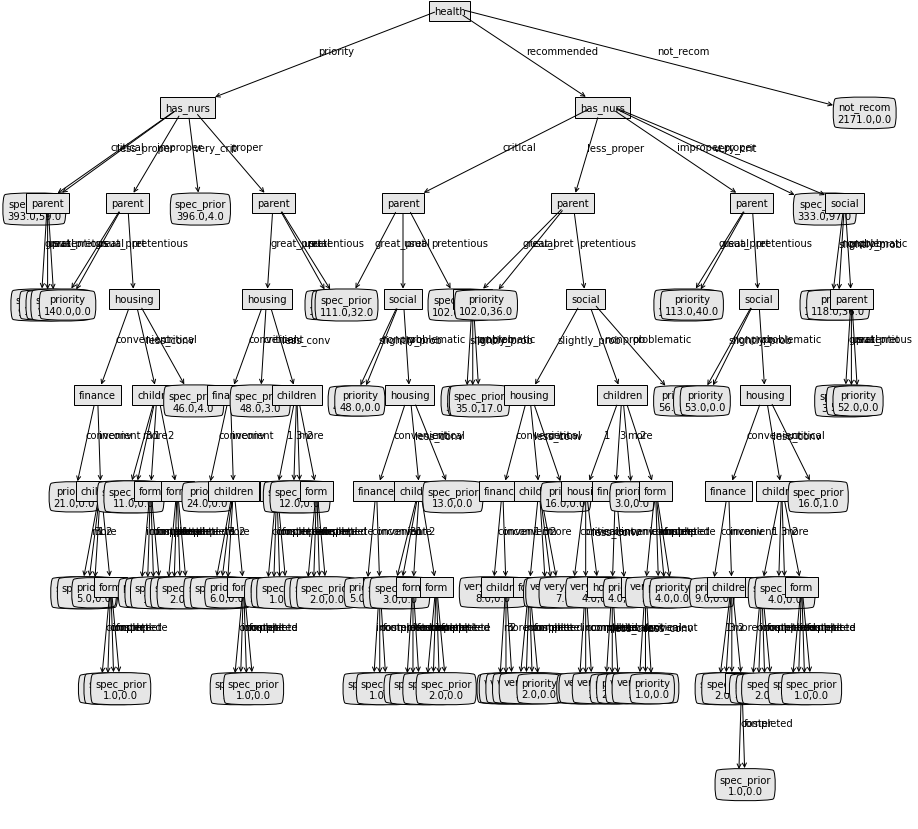

In [52]:
createPlot(my_tree)